In [4]:
!pip install sagemaker==1.72.0

     |████████████████████████████████| 297 kB 5.8 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-1.72.0-py2.py3-none-any.whl size=386358 sha256=38707a678c9036db92de7323660f0c53fe803ce9c9af08c7656782b62250c1ea
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c3/58/70/85faf4437568bfaa4c419937569ba1fe54d44c5db42406bbd7
Successfully built sagemaker
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.0
    Uninstalling smdebug-rulesconfig-1.0.0:
      Successfully uninstalled smdebug-rulesconfig-1.0.0
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.19.0
    Uninstalling sagemaker-2.19.0:
      Successfully uninstalled sagemaker-2.19.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [5]:
%matplotlib inline
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import sklearn.model_selection

import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.sklearn.estimator import SKLearn
from sklearn.preprocessing import MinMaxScaler

session = sagemaker.Session()
role = get_execution_role()

In [6]:
data_df = pd.read_csv("./data/processed_data.csv")

We will be experimenting with the following algorithms for the model:
1. XGBoost
2. Simple Custom Neural Net
3. Long Short Term Memory Networks

Before I work with these models, I will start with the benchmark model first which is based on Simple Moving Average model.

<h2> Simple Moving Average (SMA)</h2>

In Simple Moving Average, the predicted next price is equal to the average of the last $w$ data points. In addition to creating this model, I will be creating the function to implement the trading strategy in this section as well.

In [7]:
# Import source to access feature.py script
import source

In [8]:
# Since our create_features function calculate the average of the last w prices as one of our features, we can reuse it to perform SMA
def predict_sma_prices(features_df):
    return features_df['price_1_mean']

# Function to calculate Root Mean Squared of Error, an useful metric to gauge how accurate the model is
def calculate_mape(asset_matrix):
    asset_matrix['error'] = abs(1 - (asset_matrix['predicted_price']/asset_matrix['actual_price'])) * 100
    mape = sum(asset_matrix['error'])/len(asset_matrix)
    print('MAPE: {:.4f}'.format(mape))
    return mape

# Function to create a dataframe containing calculations needed to execute the trading strategy
def construct_asset_matrix(test_df, pred):
    result = test_df.copy()
    result = result[['sym', 'price_4_last', 'market_cap_4_last', 'target']]
    result.columns = ['sym', 'previous_price', 'previous_market_cap', 'actual_price']
    
    result['predicted_price'] = pred.values
    result['expected_roi'] = result['predicted_price']/result['previous_price'] - 1
    result['actual_roi'] = result['actual_price']/result['previous_price'] - 1
    
    return result

# Function to plot predicted vs actual price for a given asset using asset matrix
def plot_predicted_vs_actual(asset_matrix, sym):
    plt.figure(figsize=(10,5))

    asset_matrix[asset_matrix['sym'] == sym]['predicted_price'].plot(label='Prediction', lw=1)
    asset_matrix[asset_matrix['sym'] == sym]['actual_price'].plot(label='Actual', lw=1)

    plt.legend()
    plt.show()

In [9]:
features_df = source.create_features(data_df, w=30)
sma_pred = predict_sma_prices(features_df)

In [10]:
asset_matrix = construct_asset_matrix(features_df, sma_pred)

In [11]:
mape = calculate_mape(asset_matrix)

MAPE: inf


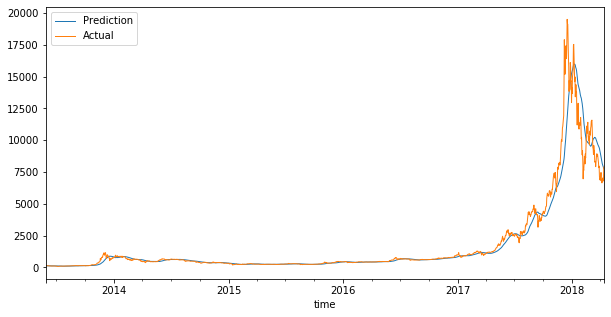

In [12]:
plot_predicted_vs_actual(asset_matrix, 'BTC')

<h2>Trading Strategy</h2>

Now that we have the predicted price for a given time period, we can build a portfolio at each time step so that we can have an idea how much profit can be generated by using the SMA prediction model. The strategy employed to build the portfolio will be standardized accross all the different prediction model we will explore later as well.

The strategy will be to invest in the top $n$ coins with the highest expected ROI and then sell it the following day. To simplify the calculation, we will be ignoring the transaction cost. As the algorithm continues to trade, it will re-evaluate the best value of $n$ for a given time period such that it maximizes the Sharpe ratio based on the predicted prices on the next time step.

We will be trading for 1 year from April 12, 2017 and April 12, 2018.

In [19]:
vol_threshold = 100000
age_threshold = 50

test_features_df = source.create_features(data_df, w=5)
test_sma_df = test_features_df[pd.to_datetime(test_features_df.index) >= pd.Timestamp('2017-04-12')]
test_sma_df = test_sma_df[(test_sma_df['volume_4_last'] * test_sma_df['price_4_last']) > vol_threshold]
test_sma_df = test_sma_df[test_sma_df['age_4_last'] > age_threshold]
test_sma_pred = predict_sma_prices(test_sma_df)
test_asset_matrix = construct_asset_matrix(test_sma_df, test_sma_pred)

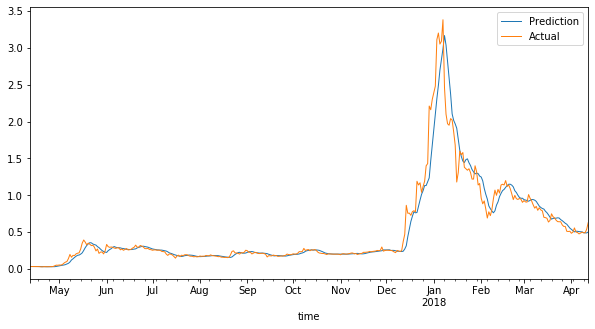

In [20]:
plot_predicted_vs_actual(test_asset_matrix, 'XRP')

In [21]:
# Function to update mean based on new value
def update_mean(mean, t, new_value):
    if t == 0:
        return new_value
    else:
        return (mean * (t - 1) + new_value) / t

# Function to update standard deviation based on new value
def update_std(std, mean, new_mean, t, new_value):
    if t == 0:
        return 0
    else:
        return np.sqrt((std ** 2 * (t - 1) + (new_value - new_mean) * (new_value - mean)) / t)

# Function to execute the trading strategy over the trading horizon using asset matrix
def evaluate_strategy(asset_matrix):
    initial_value = 10000
    total_value = initial_value
    sharpe_ratio = None
    mean_roi = 0
    std_roi = 0
    n = 5
    t = 1
    percent_returns = 0
    value_history = []
    roi_history = []
    top_roi = []

    dates = list(set(asset_matrix.index))
    dates.sort()

    for date in dates:

        coins_stats_df = asset_matrix.loc[date,:]
        coins_stats_df = coins_stats_df.sort_values(by='expected_roi', ascending=False)
        coins_stats_df = coins_stats_df[coins_stats_df['expected_roi'] > 0]
        
        if coins_stats_df.empty:
            prev_mean_roi = mean_roi
            mean_roi = update_mean(prev_mean_roi, t, 0)
            std_roi = update_std(std_roi, prev_mean_roi, mean_roi, t, 0)
            n_history.append(0)
            value_history.append(total_value)
            roi_history.append(0)
            continue
       
        day_return = sum(coins_stats_df.iloc[:n,:]['actual_roi'] * total_value / n)
        day_roi = day_return/total_value
        total_value += day_return
        percent_returns = (total_value/initial_value - 1) * 100

        prev_mean_roi = mean_roi
        mean_roi = update_mean(prev_mean_roi, t, day_roi)
        std_roi = update_std(std_roi, prev_mean_roi, mean_roi, t, day_roi)
        sharpe_ratio = mean_roi/std_roi
        
        value_history.append(total_value)
        roi_history.append(day_roi)

        t += 1
        
    print('Cumulative Returns: {:.2e}%, Sharpe Ratio: {:.4f}'.format(percent_returns, sharpe_ratio))
    
    history = pd.concat([pd.DataFrame(dates), pd.DataFrame(value_history), pd.DataFrame(roi_history)], axis=1)
    history.columns = ['time', 'total_value', 'roi']
    history = history.set_index('time')
    return sharpe_ratio, percent_returns, history

In [22]:
sma_result = evaluate_strategy(test_asset_matrix)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:55: RuntimeWarning: divide by zero encountered in double_scalars


Cumulative Returns: 1.66e+07%, Sharpe Ratio: 0.2483


In [23]:
sma_mape = calculate_mape(test_asset_matrix)

MAPE: 12.7693


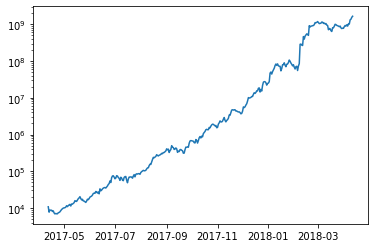

In [24]:
plt.plot(sma_result[2]['total_value'])
plt.yscale('log')
plt.show()

<h2> XGBoost </h2>

Testing on XGBoost algorithm. We will experiment using different values of $w$.

In [25]:
def run_xgboost_model(w, hyperparams, prefix, data_dir, data_df, test_start='2017-04-12', val_start='2016-04-12'):
    features_df = source.create_features(data_df, w)
    features_df = features_df[(features_df['volume_4_last'] * features_df['price_4_last']) > vol_threshold]
    features_df = features_df[features_df['age_4_last'] > age_threshold]
    
    train_df = features_df[features_df.index < pd.Timestamp(val_start)]
    val_df = features_df[(features_df.index >= pd.Timestamp(val_start)) & (features_df.index < pd.Timestamp(test_start))]
    test_df = features_df[features_df.index >= pd.Timestamp(test_start)]
    
    X_train = pd.DataFrame(train_df.iloc[:,2:-2])
    Y_train = pd.DataFrame(train_df['target'])
    X_val = pd.DataFrame(val_df.iloc[:,2:-2])
    Y_val = pd.DataFrame(val_df['target'])
    X_test = pd.DataFrame(test_df.iloc[:,2:-2])
    Y_test = pd.DataFrame(test_df['target'])
    
    
    pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)
    pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'val.csv'), header=False, index=False)

    train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)
    val_location = session.upload_data(os.path.join(data_dir, 'val.csv'), key_prefix=prefix)
    
    script_path = './source/custom_xgb.py'

    xgb_custom = XGBoost(entry_point=script_path,
                        framework_version='1.0-1',
                        hyperparameters=hyperparams,
                        role=role,
                        train_instance_count=1,
                        train_instance_type='ml.m4.xlarge',
                        output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix))
    
    s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
    s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')
    xgb_custom.fit({'train': s3_input_train, 'validation': s3_input_validation})
    
    predictor = xgb_custom.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")
    
    pred = []
    i = 0
    payload_list = [[str(entry) for entry in row] for row in X_test.values]

    for j in range(10000,len(payload_list)+10000, 10000):
        max_idx = min(len(payload_list), j)
        payload = '\n'.join([','.join(row) for row in payload_list[i:j]])
        response = session.sagemaker_runtime_client.invoke_endpoint(
                                                        EndpointName = predictor.endpoint, #predictor.endpoint,
                                                        ContentType = 'text/csv',
                                                        Body = payload)
        result = response['Body'].read().decode("utf-8")
        pred_val = ast.literal_eval(result)
        pred = pred + pred_val
        i = j
    
    asset_matrix = construct_asset_matrix(test_df, pd.DataFrame(pred))
    mape = calculate_mape(asset_matrix)
    result = evaluate_strategy(asset_matrix)
    
    session.sagemaker_client.delete_endpoint(EndpointName = predictor.endpoint)
    
    return test_df, pred, asset_matrix, result
    

In [34]:
hyperparams = {
        "max_depth": "1000",
        "eta": "0.2",
        "gamma": "0",
        "min_child_weight": "1",
        "subsample": "0.8",
        "objective": "reg:linear",
        "num_round": "50",
        "verbosity": "0",
        "early_stopping_rounds": "10"
}

In [35]:
xgb_w7 = run_xgboost_model(w=7, 
                          hyperparams=hyperparams, 
                          prefix='xgb-w7', 
                          data_dir='./data', 
                          data_df=data_df)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-01-25 14:21:29 Starting - Starting the training job......
2021-01-25 14:22:13 Starting - Launching requested ML instances.........
2021-01-25 14:23:33 Starting - Preparing the instances for training......
2021-01-25 14:24:54 Downloading - Downloading input data
2021-01-25 14:24:54 Training - Downloading the training image.....INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
INFO:sagemaker-containers:Module custom_xgb does not provide a setup.py. 
Generating setup.py
INFO:sagemaker-containers:Generating setup.cfg
INFO:sagemaker-containers:Generating MANIFEST.in
INFO:sagemaker-containers:Installing module with the following command:
/miniconda3/bin/python -m pip install . 
Processing /opt/ml/code
  Created wheel for custom-xgb: filename=custom_xgb-1.0.0-py2.py3-none-any.whl size=6015 sha256=af858864de0522b6

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


Training seconds: 77
Billable seconds: 77
---------------!MAPE: 69.0077


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:55: RuntimeWarning: divide by zero encountered in double_scalars


Cumulative Returns: -3.95e+01%, Sharpe Ratio: 0.0355


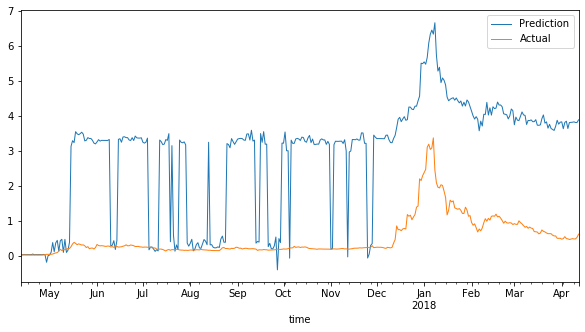

In [36]:
plot_predicted_vs_actual(xgb_w7[2], 'XRP')

In [37]:
xgb_w10 = run_xgboost_model(w=10, 
                          hyperparams=hyperparams, 
                          prefix='xgb-w10', 
                          data_dir='./data', 
                          data_df=data_df)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-01-25 14:33:57 Starting - Starting the training job...
2021-01-25 14:34:00 Starting - Launching requested ML instances......
2021-01-25 14:35:04 Starting - Preparing the instances for training...
2021-01-25 14:35:57 Downloading - Downloading input data......
2021-01-25 14:36:56 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
INFO:sagemaker-containers:Module custom_xgb does not provide a setup.py. 
Generating setup.py
INFO:sagemaker-containers:Generating setup.cfg
INFO:sagemaker-containers:Generating MANIFEST.in
INFO:sagemaker-containers:Installing module with the following command:
/miniconda3/bin/python -m pip install . 
Processing /opt/ml/code
  Created wheel for custom-xgb: filename=custom_xgb-1.0.0-py2.py3-none-any.whl size=6015 sha2

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


Training seconds: 83
Billable seconds: 83
-----------------!MAPE: 943.4154


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:55: RuntimeWarning: divide by zero encountered in double_scalars


Cumulative Returns: 2.14e+02%, Sharpe Ratio: 0.0803


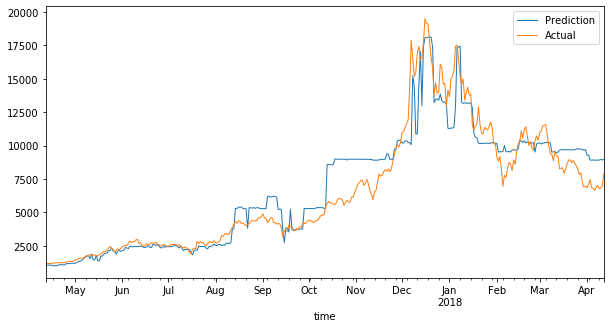

In [38]:
plot_predicted_vs_actual(xgb_w10[2], 'BTC')

In [ ]:
xgb_w5 = run_xgboost_model(w=5, 
                          hyperparams=hyperparams, 
                          prefix='xgb-w5', 
                          data_dir='./data', 
                          data_df=data_df)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-01-25 17:08:54 Starting - Starting the training job.

In [ ]:
plot_predicted_vs_actual(xgb_w5[2], 'BTC')

<h2> Custom Neural Network </h2>

Testing on XGBoost algorithm. We will experiement using different values of $w$.

In [292]:
w=5
prefix='mlp-w50'
data_dir='./data'
data_df=data_df
test_start='2017-04-12' 
val_start='2016-04-12'
market_cap_threshold=100000

In [339]:
def run_mlp_model(w, hyperparams, prefix, data_dir, data_df, test_start='2017-04-12', val_start='2016-04-12'):
    features_df = source.create_features(data_df, w)
    features_df = features_df[(features_df['volume_4_last'] * features_df['price_4_last']) > vol_threshold]
    features_df = features_df[features_df['age_4_last'] > age_threshold]
    
    scaler = MinMaxScaler()
    for column in features_df.iloc[:,2:-2].columns:
        features_df[column] = scaler.fit_transform(features_df[[column]])

    train_df = features_df[features_df.index < pd.Timestamp(test_start)]
#     val_df = features_df[(features_df.index >= pd.Timestamp(val_start)) & (features_df.index < pd.Timestamp(test_start))]
    test_df = features_df[features_df.index >= pd.Timestamp(test_start)]

    X_train = pd.DataFrame(train_df.iloc[:,2:-2])
    Y_train = pd.DataFrame(train_df['target'])
#     X_val = pd.DataFrame(val_df.iloc[:,2:-2])
#     Y_val = pd.DataFrame(val_df['target'])
    X_test = pd.DataFrame(test_df.iloc[:,2:-2])
    Y_test = pd.DataFrame(test_df['target'])

    train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

    estimator = SKLearn(entry_point='train.py',
                        source_dir='source',
                        role=role,
                        train_instance_count=1, 
                        train_instance_type='ml.c4.xlarge',
                        framework_version='0.23-1',
                        py_version='py3',
                        output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                        sagemaker_session=session,
                        hyperparameters={
                            'hidden_layers': 50,
                            'max_iter': 10
                        })

    estimator.fit({'train': train_location})
    
    predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium")
    
    pred = []
    i = 0
    payload_list = [[str(entry) for entry in row] for row in X_test.values]

    for j in range(10000,len(payload_list)+10000, 10000):
        max_idx = min(len(payload_list), j)
        payload = '\n'.join([','.join(row) for row in payload_list[i:j]])
        response = session.sagemaker_runtime_client.invoke_endpoint(
                                                        EndpointName = predictor.endpoint,
                                                        ContentType = 'text/csv',
                                                        Body = payload)
        result = response['Body'].read().decode("utf-8")
        pred_val = ast.literal_eval(result)
        pred = pred + pred_val
        i = j

    asset_matrix = construct_asset_matrix(test_df, pd.DataFrame(pred))
    mape = calculate_mape(asset_matrix)
    result = evaluate_strategy(asset_matrix)

    session.sagemaker_client.delete_endpoint(EndpointName = predictor.endpoint)

    return asset_matrix, mape, result

In [344]:
xgb_w7 = run_mlp_model(w=7, 
                      hyperparams=hyperparams, 
                      prefix='xgb-w7', 
                      data_dir='./data', 
                      data_df=data_df)

inf

<h2> LTSM </h2>

Testing on XGBoost algorithm. We will experiement using different values of $w$.

In [ ]:
features_df = source.create_features(data_df, w)
features_df = features_df[features_df['market_cap_4_last'] > market_cap_threshold]

train_df = features_df[features_df.index < pd.Timestamp(val_start)]
val_df = features_df[(features_df.index >= pd.Timestamp(val_start)) & (features_df.index < pd.Timestamp(test_start))]
test_df = features_df[features_df.index >= pd.Timestamp(test_start)]

X_train = pd.DataFrame(train_df.iloc[:,2:-2])
Y_train = pd.DataFrame(train_df['target'])
X_val = pd.DataFrame(val_df.iloc[:,2:-2])
Y_val = pd.DataFrame(val_df['target'])
X_test = pd.DataFrame(test_df.iloc[:,2:-2])
Y_test = pd.DataFrame(test_df['target'])

train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

estimator = SKLearn(entry_point='train.py',
                    source_dir='source',
                    role=role,
                    train_instance_count=1, 
                    train_instance_type='ml.c4.xlarge',
                    framework_version='0.23-1',
                    py_version='py3',
                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                    sagemaker_session=session,
                    hyperparameters={
                        'hidden_layers': 20,
                        'max_iter': 50
                    })

estimator.fit({'train': train_location})